In [1]:
import numpy as np
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import dtnnlib as dtnn

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## Building 2D model

In [3]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

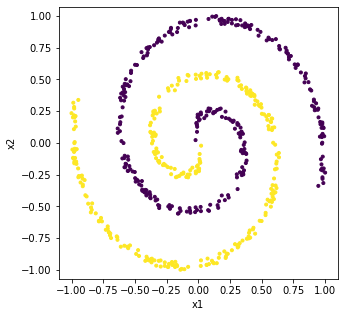

In [4]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [5]:
xx, yy = xx.to(device), yy.to(device)

## Distance Based Classification

In [6]:
# class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
#     def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
#         super().__init__(input_dim, num_centers, p=2)
        
#         nc = num_centers
#         if epsilon is not None:
#             nc += 1
#         self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
#         self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
#         self.epsilon = epsilon
        
#     def forward(self, x):
#         dists = super().forward(x)
        
#         if self.epsilon is not None:
#             dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
#         ### normalize similar to UMAP
#         dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)
        
#         ## scale the dists
# #         dists = torch.exp(-dists + self.scaler)
#         dists = 1-dists*torch.exp(self.scaler)
    
#         if self.bias is not None: dists = dists+self.bias
#         return dists

In [447]:
# class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
#     def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
#         super().__init__(input_dim, num_centers, p=2)
        
#         nc = num_centers
#         if epsilon is not None:
#             nc += 1
#         self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
# #         self.scaler = nn.Parameter(torch.ones(1, 1)*1)

#         self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
#         self.epsilon = epsilon
        
#     def forward(self, x):
#         dists = super().forward(x)
        
#         if self.epsilon is not None:
#             dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
#         ### normalize similar to UMAP
# #         dists = dists/dists.std(dim=1, keepdim=True, unbiased=False)
# #         dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True, unbiased=False))
# #         dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True, unbiased=False)+1e-99) ## does not produce maxima at centers... (TEST by replacing this and below line) 
# #         dists = dists/(torch.norm(dists, dim=1, keepdim=True)+1e-99) ## does produce maxima at centers !! (scales to high dimensions ?)
# #         dists = dists/torch.norm(dists, dim=1, keepdim=True) ## does produce maxima at centers !! (scales to high dimensions ?)
        
#         ## scale the dists
# #         dists = torch.exp(-dists + self.scaler)
# #         dists = torch.exp(-dists)*self.scaler
#         dists = 1-dists*torch.exp(self.scaler)
# #         dists = 1-dists*self.scaler
# #         dists = 1-torch.log(dists*torch.exp(self.scaler) + 1)    
    
#         if self.bias is not None: dists = dists+self.bias
#         return dists

In [1753]:
class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        nc = num_centers
        if epsilon is not None:
            nc += 1
        self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
#         self.scaler = nn.Parameter(torch.ones(1, 1)*1)

        self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        if self.epsilon is not None:
            dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
#         dists = dists**2 ### creates similar to RBF -> e^(x^2) when used with softmax EXPERIMENT: Center!=maxima
        dists = -dists
        dists = torch.exp(dists) ### solves degenerate cases of centers != maxima

        dists = dists/torch.norm(dists, p=2, dim=1, keepdim=True).data ## does produce maxima at centers !! (scales to high dimensions ?) (false when no exponential scale)
        ## ^^ This is similar to softmax if p=1 (i.e sum), 2 means something different.. Double Softmax ?!..
        dists = dists*torch.exp(self.scaler)
#         dists = dists*self.scaler

        if self.bias is not None: dists = dists+self.bias
        return dists

In [1754]:
# class DTeSM(DistanceTransform_Epsilon):
    
#     def __init__(self, input_dim, output_dim, epsilon=1.0):
#         super().__init__(input_dim, output_dim, bias=True, epsilon=epsilon)
        
#         self.scale_shift = dtnn.ScaleShift(-1, scaler_init=10, shifter_init=0, scaler_const=True, shifter_const=True)
#         self.softmax = nn.Softmax(dim=-1)
#         self.temp_activ = None
        
#     def forward(self, x):
#         xo = super().forward(x)
#         xo = self.scale_shift(xo)
#         xo = self.softmax(xo)
#         self.temp_activ = xo.data
# #         return xo[:, :-1]
#         return xo

In [1755]:
class DT_epsilon_Classifier(DistanceTransform_Epsilon):
    
    def __init__(self, input_dim, output_dim, epsilon=1.0):
        super().__init__(input_dim, output_dim, bias=True, epsilon=epsilon)
        
    def forward(self, x):
        xo = super().forward(x)
#         return xo[:, :-1]
        return F.softmax(xo, dim=-1)

In [1756]:
## reshape for multi-class classification (including epsilon)
yy = yy.reshape(-1).type(torch.LongTensor)

In [1757]:
model = DT_epsilon_Classifier(2, 2, epsilon=0.5)

In [1758]:
yout = model(xx)
yout.shape

torch.Size([600, 3])

In [1759]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

In [1760]:
def criterion(output, target):
    return F.nll_loss(torch.log(output), target)

Epoch: 99, Acc:0.35, Loss:1.0787389278411865
Epoch: 199, Acc:0.66, Loss:1.008951187133789
Epoch: 299, Acc:0.71, Loss:0.9547256231307983
Epoch: 399, Acc:0.71, Loss:0.9129834175109863
Epoch: 499, Acc:0.71, Loss:0.8801777362823486
Epoch: 599, Acc:0.71, Loss:0.8533621430397034
Epoch: 699, Acc:0.71, Loss:0.8307985663414001
Epoch: 799, Acc:0.71, Loss:0.8114022016525269
Epoch: 899, Acc:0.71, Loss:0.7943756580352783
Epoch: 999, Acc:0.71, Loss:0.7790161967277527


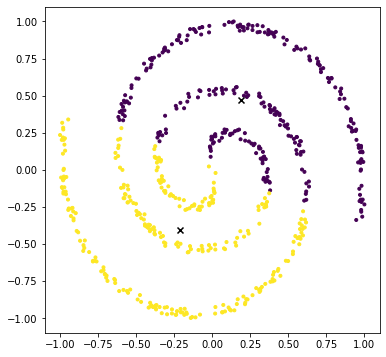

Epoch: 1099, Acc:0.71, Loss:0.7641364932060242
Epoch: 1199, Acc:0.71, Loss:0.7480833530426025
Epoch: 1299, Acc:0.71, Loss:0.7329759001731873
Epoch: 1399, Acc:0.71, Loss:0.7212011814117432
Epoch: 1499, Acc:0.71, Loss:0.7110834121704102
Epoch: 1599, Acc:0.71, Loss:0.701916515827179
Epoch: 1699, Acc:0.70, Loss:0.6937060952186584
Epoch: 1799, Acc:0.71, Loss:0.6863279342651367
Epoch: 1899, Acc:0.71, Loss:0.6797218322753906
Epoch: 1999, Acc:0.71, Loss:0.6737841963768005


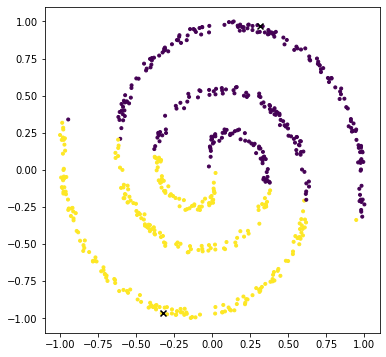

Epoch: 2099, Acc:0.71, Loss:0.6684202551841736
Epoch: 2199, Acc:0.71, Loss:0.6635814905166626
Epoch: 2299, Acc:0.71, Loss:0.659201979637146
Epoch: 2399, Acc:0.71, Loss:0.6552213430404663
Epoch: 2499, Acc:0.71, Loss:0.6515889167785645
Epoch: 2599, Acc:0.71, Loss:0.6482621431350708
Epoch: 2699, Acc:0.71, Loss:0.6452059149742126
Epoch: 2799, Acc:0.71, Loss:0.642388641834259
Epoch: 2899, Acc:0.71, Loss:0.6397843360900879
Epoch: 2999, Acc:0.71, Loss:0.6373684406280518


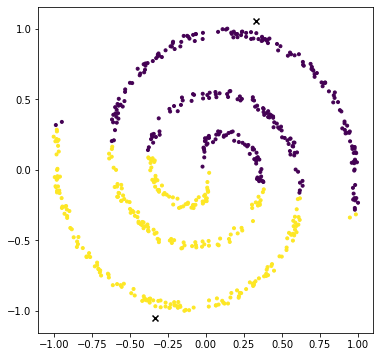

Epoch: 3099, Acc:0.71, Loss:0.6351228952407837
Epoch: 3199, Acc:0.71, Loss:0.6330287456512451
Epoch: 3299, Acc:0.71, Loss:0.6310703754425049
Epoch: 3399, Acc:0.71, Loss:0.6292360424995422
Epoch: 3499, Acc:0.71, Loss:0.6275134682655334
Epoch: 3599, Acc:0.71, Loss:0.6258928179740906
Epoch: 3699, Acc:0.71, Loss:0.624363362789154
Epoch: 3799, Acc:0.71, Loss:0.6229186654090881
Epoch: 3899, Acc:0.71, Loss:0.621550977230072
Epoch: 3999, Acc:0.71, Loss:0.6202536225318909


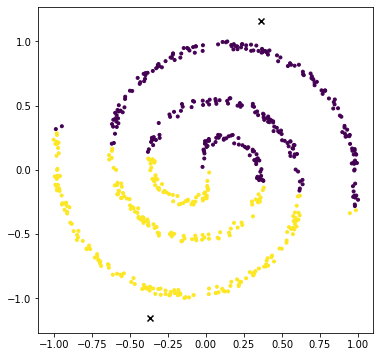

Epoch: 4099, Acc:0.71, Loss:0.619022011756897
Epoch: 4199, Acc:0.71, Loss:0.6178498864173889
Epoch: 4299, Acc:0.71, Loss:0.6167332530021667
Epoch: 4399, Acc:0.71, Loss:0.6156677007675171
Epoch: 4499, Acc:0.71, Loss:0.6146493554115295
Epoch: 4599, Acc:0.71, Loss:0.6136759519577026
Epoch: 4699, Acc:0.71, Loss:0.6127430200576782
Epoch: 4799, Acc:0.71, Loss:0.6118487119674683
Epoch: 4899, Acc:0.71, Loss:0.6109897494316101
Epoch: 4999, Acc:0.71, Loss:0.6101642847061157


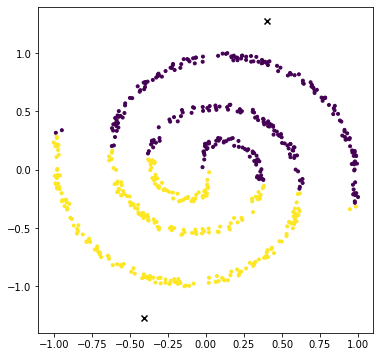

In [1761]:
%matplotlib inline

for epoch in range(5000):
# for epoch in range(1000):
    yout = model(xx)
    
#     yout.register_hook(lambda grad: grad/torch.norm(grad, dim=1, keepdim=True))
    
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#     model.bias.data *= 0. ## Neglect the bias use

    if (epoch+1)%100 == 0:
        yout = model(xx)
        accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = yout.max(dim=1)[1].data.cpu().numpy()
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [1762]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)
XX.shape

torch.Size([1000000, 2])

### Repeat below after changing parameters

In [1763]:
# YY = F.softmax(model(XX), dim=-1)
YY = model(XX)
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 3])

In [1764]:
yout = model(xx)
out = yout.max(dim=1)[1].data.cpu().numpy()

In [1765]:
max_actv = model(model.centers.data).data.cpu()
max_actv = max_actv.diag().numpy()
max_actv

array([0.8773658 , 0.87768805], dtype=float32)

center: 0.8773658 max_grid: 0.8771111 True


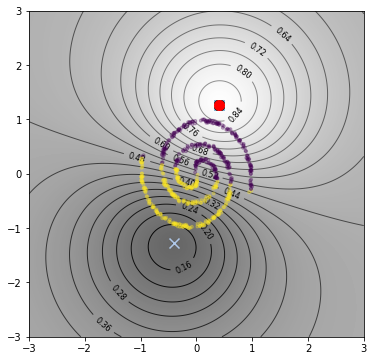

center: 0.87768805 max_grid: 0.8774154 True


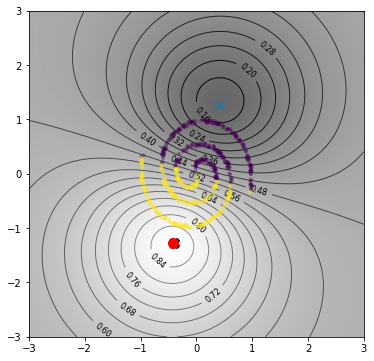

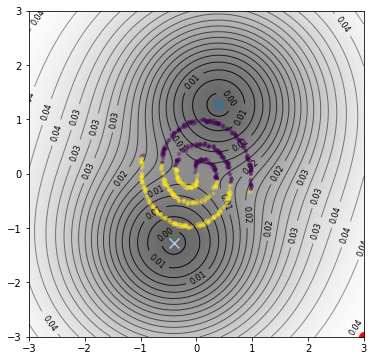

In [1766]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.centers.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [1767]:
model.bias.data, model.scaler, torch.exp(model.scaler)

(tensor([[ 2.4325,  2.4340, -2.4336]]), Parameter containing:
 tensor([[0.9200]], requires_grad=True), tensor([[2.5092]], grad_fn=<ExpBackward>))

In [1768]:
"""
IT SEEMS - scaling distance by 1/std does not produce maxima at centers... however, 1/norm does... (scales to high dimensions ?) 
                    --?? does it solve problem in 02.10 ?
                    -- scaling by 1/std should work fine ?? its constant scaling, it should !!
                    
        vv(bellow)-- experienting, it seems even using /norm or no divide, there exists case when two centers are close,,
                the maximum_actf > center_actf (precision error ?? or some underlying mechanism)
                can't find this for exp(-dist+scale) 
                
First scaling dists (by increasing function like exponential) and dividing by norm preserves center == maxima ??
"""
print()

## Changing parameters

In [1769]:
model.bias.data[0] = torch.Tensor([0, 0, -1])

In [1770]:
model.scaler.data[0,0] = 3.

### DTeSM Residual 

In [1771]:
class DTeSM(DistanceTransform_Epsilon):
    
    def __init__(self, input_dim, output_dim, epsilon=1.0, itemp=10):
        ### NOTE: Here, not using bias leads to more uniform centroid activation, and easy to compare..
        super().__init__(input_dim, output_dim, bias=False, epsilon=epsilon)
        
        self.scale_shift = dtnn.ScaleShift(-1, scaler_init=itemp, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
        self.temp_activ = None
        
    def forward(self, x):
        xo = super().forward(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        self.temp_activ = xo.data
#         return xo[:, :-1]
        return xo

In [1772]:
class LocalResidual_DTeSM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, epsilon=None, itemp=1.0):
        super().__init__()
        self.layer0 = DTeSM(input_dim, hidden_dim, epsilon, itemp)
        if epsilon is not None:
            hidden_dim += 1
        self.layer1 = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        h = self.layer0(x)
        h = x + self.layer1(h)
        return h

In [1773]:
model = LocalResidual_DTeSM(2, 5, epsilon=2.0, itemp=5.0)
model(xx).shape

torch.Size([600, 2])

In [1774]:
model.layer0.temp_activ

tensor([[0.2082, 0.0976, 0.4286, 0.1284, 0.1032, 0.0339],
        [0.0888, 0.2574, 0.0823, 0.0945, 0.4414, 0.0356],
        [0.3334, 0.0979, 0.2566, 0.2154, 0.0661, 0.0306],
        ...,
        [0.2149, 0.0917, 0.4226, 0.1316, 0.0985, 0.0407],
        [0.2733, 0.1716, 0.1960, 0.2275, 0.1004, 0.0311],
        [0.2682, 0.1187, 0.3256, 0.1663, 0.0907, 0.0303]])

In [1775]:
model = nn.Sequential(
            LocalResidual_DTeSM(2, 10, epsilon=1.0, itemp=10.0),
            DT_epsilon_Classifier(2, 2, epsilon=1.0)
            )

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [1776]:
yout = model(xx)
yout.shape

torch.Size([600, 3])

In [1777]:
model[0].layer1.weight.data[:, -1] = model[0].layer1.weight.data[:, -1]*0-5.0

In [1778]:
# yy = yy.reshape(-1).type(torch.LongTensor)

In [1779]:
# def criterion(output, target):
#     return F.nll_loss(torch.log(output), target)

Epoch: 99, Acc:0.38, Loss:1.0821245908737183
Epoch: 199, Acc:0.47, Loss:1.0548490285873413
Epoch: 299, Acc:0.61, Loss:1.0147409439086914
Epoch: 399, Acc:0.75, Loss:0.9598560333251953
Epoch: 499, Acc:0.91, Loss:0.8887087106704712
Epoch: 599, Acc:0.92, Loss:0.8324650526046753
Epoch: 699, Acc:0.95, Loss:0.7788387537002563
Epoch: 799, Acc:0.98, Loss:0.7280182838439941
Epoch: 899, Acc:0.99, Loss:0.6817511916160583
Epoch: 999, Acc:0.99, Loss:0.6465163230895996


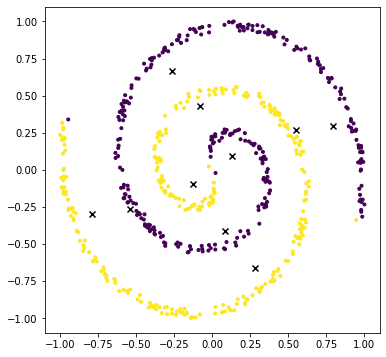

Epoch: 1099, Acc:1.00, Loss:0.6219514608383179
Epoch: 1199, Acc:1.00, Loss:0.6045675873756409
Epoch: 1299, Acc:1.00, Loss:0.5915101766586304
Epoch: 1399, Acc:1.00, Loss:0.5810412168502808
Epoch: 1499, Acc:1.00, Loss:0.5747900009155273
Epoch: 1599, Acc:1.00, Loss:0.5694094300270081
Epoch: 1699, Acc:1.00, Loss:0.5663582682609558
Epoch: 1799, Acc:1.00, Loss:0.564083993434906
Epoch: 1899, Acc:1.00, Loss:0.5623218417167664
Epoch: 1999, Acc:1.00, Loss:0.5609280467033386


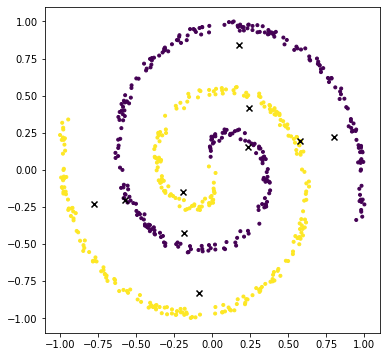

Epoch: 2099, Acc:1.00, Loss:0.5598049163818359
Epoch: 2199, Acc:1.00, Loss:0.5588914752006531
Epoch: 2299, Acc:1.00, Loss:0.5581396222114563
Epoch: 2399, Acc:1.00, Loss:0.557513415813446
Epoch: 2499, Acc:1.00, Loss:0.5569878816604614
Epoch: 2599, Acc:1.00, Loss:0.5565430521965027
Epoch: 2699, Acc:1.00, Loss:0.556163489818573
Epoch: 2799, Acc:1.00, Loss:0.5558372735977173
Epoch: 2899, Acc:1.00, Loss:0.5555554628372192
Epoch: 2999, Acc:1.00, Loss:0.5553112030029297


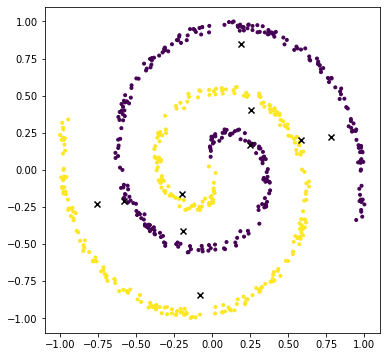

Epoch: 3099, Acc:1.00, Loss:0.5550965666770935
Epoch: 3199, Acc:1.00, Loss:0.554908812046051
Epoch: 3299, Acc:1.00, Loss:0.5547431707382202
Epoch: 3399, Acc:1.00, Loss:0.5545962452888489
Epoch: 3499, Acc:1.00, Loss:0.5544662475585938
Epoch: 3599, Acc:1.00, Loss:0.5543497204780579
Epoch: 3699, Acc:1.00, Loss:0.5542454123497009
Epoch: 3799, Acc:1.00, Loss:0.554152250289917
Epoch: 3899, Acc:1.00, Loss:0.5540682077407837
Epoch: 3999, Acc:1.00, Loss:0.5539916753768921


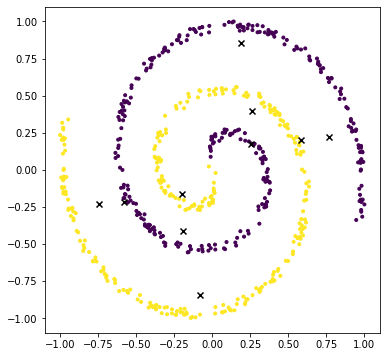

Epoch: 4099, Acc:1.00, Loss:0.5539230108261108
Epoch: 4199, Acc:1.00, Loss:0.5538610816001892
Epoch: 4299, Acc:1.00, Loss:0.553804337978363
Epoch: 4399, Acc:1.00, Loss:0.5537522435188293
Epoch: 4499, Acc:1.00, Loss:0.5537048578262329
Epoch: 4599, Acc:1.00, Loss:0.5536618828773499
Epoch: 4699, Acc:1.00, Loss:0.5536227226257324
Epoch: 4799, Acc:1.00, Loss:0.553586483001709
Epoch: 4899, Acc:1.00, Loss:0.5535531044006348
Epoch: 4999, Acc:1.00, Loss:0.5535228252410889


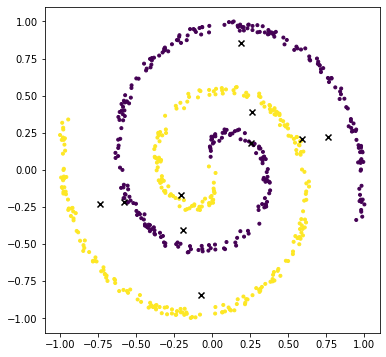

In [1780]:
%matplotlib inline

for epoch in range(5000):
    yout = model(xx)
    
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#     model.bias.data *= 0. ## Neglect the bias use
#     model[0].layer0.scaler.data = model[0].layer0.scaler.data*0+1.
    model[0].layer1.weight.data[:, -1] = model[0].layer1.weight.data[:, -1]*0

    if (epoch+1)%100 == 0:
        yout = model(xx)
        accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = yout.max(dim=1)[1].data.cpu().numpy()
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model[0].layer0.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [1781]:
model[0]

LocalResidual_DTeSM(
  (layer0): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer1): Linear(in_features=11, out_features=2, bias=True)
)

In [1782]:
h1 = model[0](xx)
yout = model[1](h1)
out = yout.max(dim=1)[1].data.cpu().numpy()
## centroids and shift
c = model[0].layer0.centers.data.cpu()
d = model[0].layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

In [1783]:
max_actv = model[0].layer0(model[0].layer0.centers.data).data.cpu()
max_actv = max_actv.diag()#.numpy()
max_actv

tensor([1.0000, 1.0000, 0.9999, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999,
        0.9999])

In [1784]:
# d[:10] = d[:10]*max_actv.unsqueeze(-1)

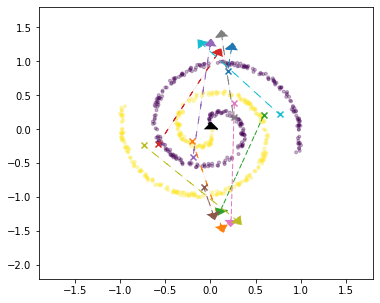

In [1785]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)
    
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

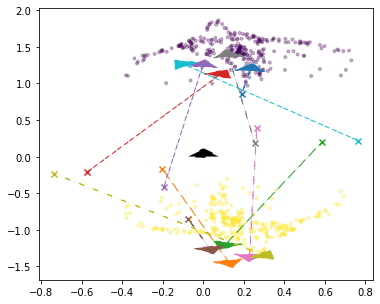

In [1786]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(h1.data[:,0], h1.data[:,1], c=out, marker= '.', alpha=0.3)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
color = "k"
ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)
    
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

### Visualize residual layer

In [1787]:
model[0](XX)
YY = model[0].layer0.temp_activ
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 11])

In [1788]:
# dir(model[0].layer0)
max_actv = max_actv.numpy()
max_actv

array([1.        , 0.9999932 , 0.99990153, 0.9998361 , 0.999995  ,
       1.        , 0.9999794 , 0.9999738 , 0.9999056 , 0.999949  ],
      dtype=float32)

center: 1.0 max_grid: 1.0 True


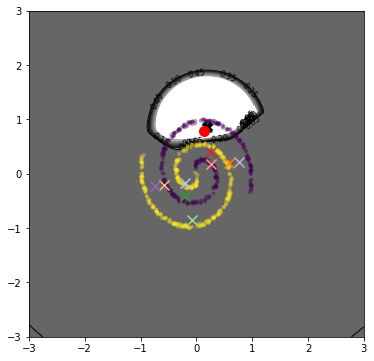

center: 0.9999932 max_grid: 0.99999297 True


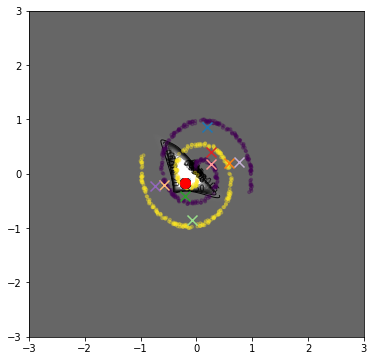

center: 0.99990153 max_grid: 0.9998976 True


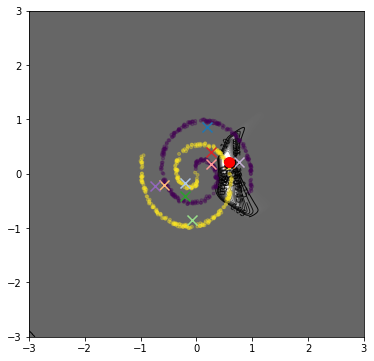

center: 0.9998361 max_grid: 0.9998209 True


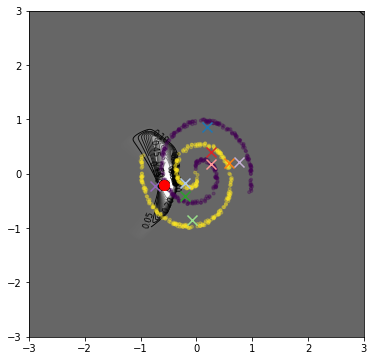

center: 0.999995 max_grid: 0.9999949 True


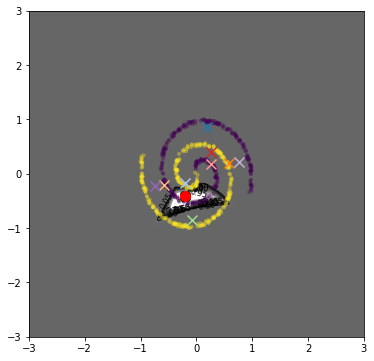

center: 1.0 max_grid: 1.0 True


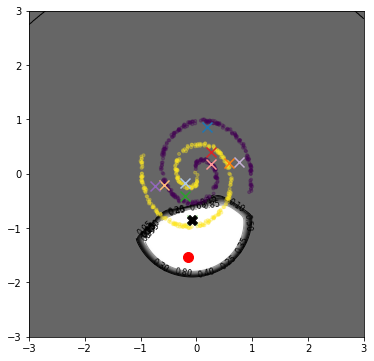

center: 0.9999794 max_grid: 0.9999783 True


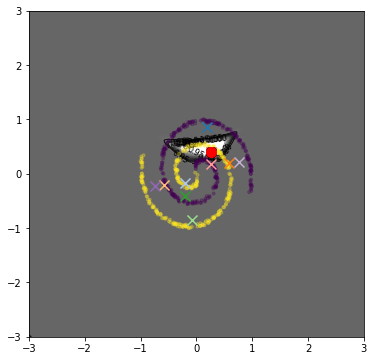

center: 0.9999738 max_grid: 0.9999733 True


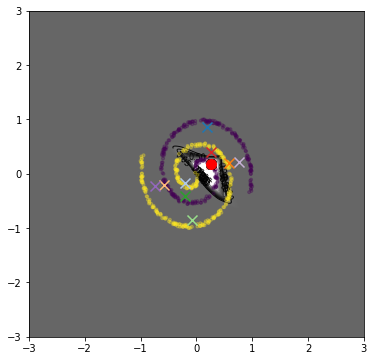

center: 0.9999056 max_grid: 0.9999037 True


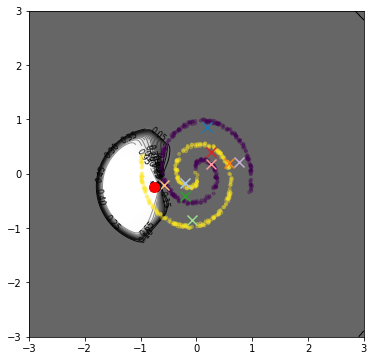

center: 0.999949 max_grid: 0.9999486 True


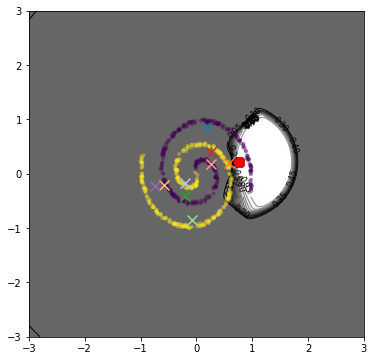

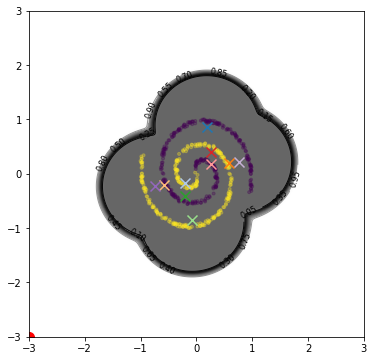

In [1789]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [1790]:
model[0].layer0.scaler, torch.exp(model[0].layer0.scaler), model[0].layer0.bias

(Parameter containing:
 tensor([[2.3799]], requires_grad=True),
 tensor([[10.8042]], grad_fn=<ExpBackward>),
 None)

### Visualize Classification Layer

In [1791]:
# YY = F.softmax(model(XX), dim=-1)
YY = model[1](XX)
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 3])

In [1792]:
max_actv = model[1](model[1].centers.data).data.cpu()
max_actv = max_actv.diag().numpy()
max_actv

array([0.9998523, 0.9998592], dtype=float32)

In [1793]:
c = model[1].centers.data.cpu()
h1 = model[0](xx)

center: 0.9998523 max_grid: 0.99985075 True


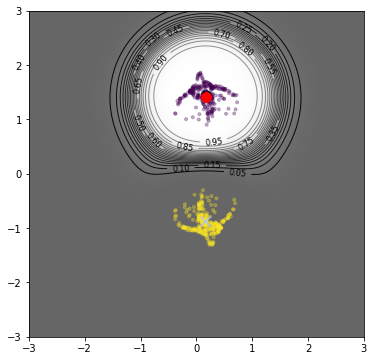

center: 0.9998592 max_grid: 0.99985826 True


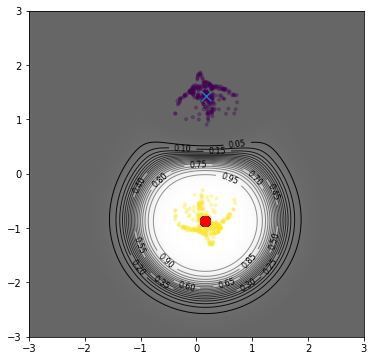

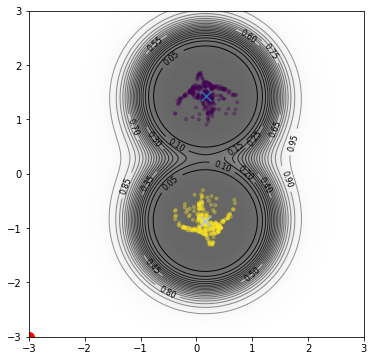

In [1794]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(h1.data[:,0], h1.data[:,1], c=out, marker= '.', alpha=0.3)

    ## plot centroids
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [1795]:
model[1].scaler, model[1].bias

(Parameter containing:
 tensor([[2.4616]], requires_grad=True), Parameter containing:
 tensor([[ 1.1727,  1.2075, -1.1919]], requires_grad=True))

In [1796]:
"""
Test various configurations if they prodice maxima==center by keeping two centers very close (the edge case..)
"""

'\nTest various configurations if they prodice maxima==center by keeping two centers very close (the edge case..)\n'

## GREEDY fit Residual Classifier with data based initialization

#### Train classifier layer first

In [1797]:
model = DT_epsilon_Classifier(2, 2, epsilon=0.5)

In [1798]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [1799]:
def criterion(output, target):
    return F.nll_loss(torch.log(output), target)

Epoch: 99, Acc:0.35, Loss:1.1306627988815308
Epoch: 199, Acc:0.45, Loss:1.0553419589996338
Epoch: 299, Acc:0.44, Loss:0.9958322048187256
Epoch: 399, Acc:0.47, Loss:0.9485117793083191
Epoch: 499, Acc:0.49, Loss:0.9101431369781494
Epoch: 599, Acc:0.52, Loss:0.8787038326263428
Epoch: 699, Acc:0.56, Loss:0.8523078560829163
Epoch: 799, Acc:0.59, Loss:0.8302236199378967
Epoch: 899, Acc:0.62, Loss:0.8115655779838562
Epoch: 999, Acc:0.64, Loss:0.7955084443092346


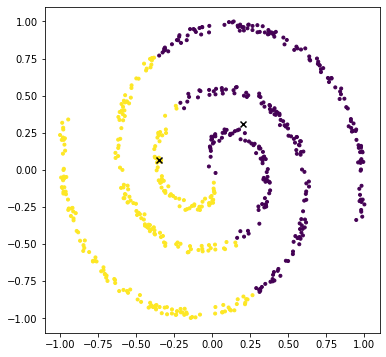

Epoch: 1099, Acc:0.66, Loss:0.7818579077720642
Epoch: 1199, Acc:0.67, Loss:0.7697696089744568
Epoch: 1299, Acc:0.68, Loss:0.7589654326438904
Epoch: 1399, Acc:0.68, Loss:0.7491252422332764
Epoch: 1499, Acc:0.68, Loss:0.7392980456352234
Epoch: 1599, Acc:0.67, Loss:0.7295212745666504
Epoch: 1699, Acc:0.66, Loss:0.7210264801979065
Epoch: 1799, Acc:0.66, Loss:0.7133139371871948
Epoch: 1899, Acc:0.68, Loss:0.7059372663497925
Epoch: 1999, Acc:0.69, Loss:0.6988113522529602


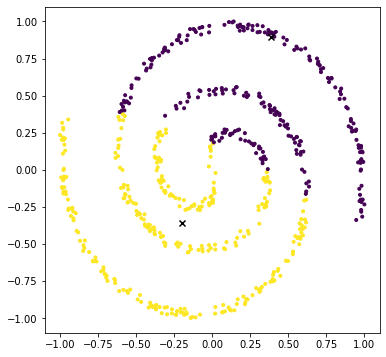

Epoch: 2099, Acc:0.69, Loss:0.6921299695968628
Epoch: 2199, Acc:0.70, Loss:0.6856312155723572
Epoch: 2299, Acc:0.71, Loss:0.6778977513313293
Epoch: 2399, Acc:0.70, Loss:0.6700789928436279
Epoch: 2499, Acc:0.70, Loss:0.6635457277297974
Epoch: 2599, Acc:0.71, Loss:0.6578842997550964
Epoch: 2699, Acc:0.71, Loss:0.6528478264808655
Epoch: 2799, Acc:0.71, Loss:0.6484057903289795
Epoch: 2899, Acc:0.71, Loss:0.6446343660354614
Epoch: 2999, Acc:0.71, Loss:0.6416176557540894


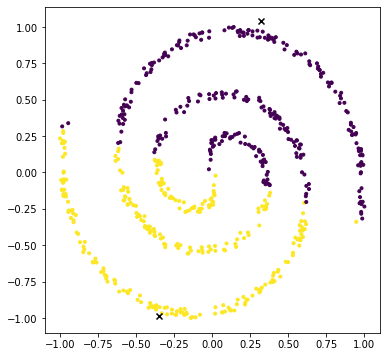

Epoch: 3099, Acc:0.71, Loss:0.6388964056968689
Epoch: 3199, Acc:0.71, Loss:0.6363938450813293
Epoch: 3299, Acc:0.71, Loss:0.6340801119804382
Epoch: 3399, Acc:0.71, Loss:0.6319335699081421
Epoch: 3499, Acc:0.71, Loss:0.6299374103546143
Epoch: 3599, Acc:0.71, Loss:0.6280773878097534
Epoch: 3699, Acc:0.71, Loss:0.6263386011123657
Epoch: 3799, Acc:0.71, Loss:0.6247107982635498
Epoch: 3899, Acc:0.71, Loss:0.6231810450553894
Epoch: 3999, Acc:0.71, Loss:0.6217422485351562


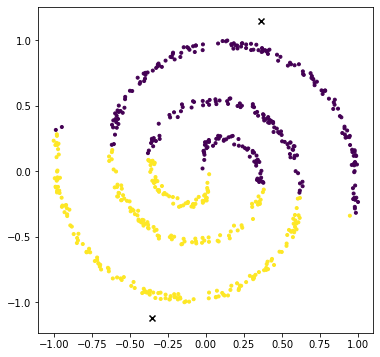

Epoch: 4099, Acc:0.71, Loss:0.620385468006134
Epoch: 4199, Acc:0.71, Loss:0.6191019415855408
Epoch: 4299, Acc:0.71, Loss:0.6178866028785706
Epoch: 4399, Acc:0.71, Loss:0.6167336702346802
Epoch: 4499, Acc:0.71, Loss:0.6156367659568787
Epoch: 4599, Acc:0.71, Loss:0.6145929098129272
Epoch: 4699, Acc:0.71, Loss:0.6135974526405334
Epoch: 4799, Acc:0.71, Loss:0.6126460433006287
Epoch: 4899, Acc:0.71, Loss:0.6117368340492249
Epoch: 4999, Acc:0.71, Loss:0.6108652949333191


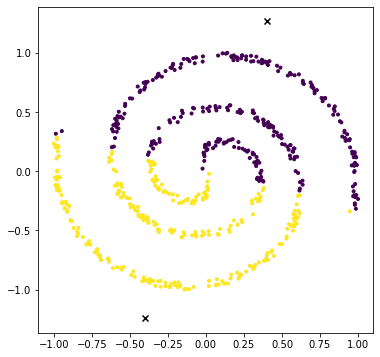

In [1800]:
%matplotlib inline

for epoch in range(5000):
    yout = model(xx)
#     yout.register_hook(lambda grad: grad/torch.norm(grad, dim=1, keepdim=True))
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1)%100 == 0:
        yout = model(xx)
        accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = yout.max(dim=1)[1].data.cpu().numpy()
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [1801]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)
XX.shape

torch.Size([1000000, 2])

In [1802]:
# YY = F.softmax(model(XX), dim=-1)
YY = model(XX)
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 3])

In [1803]:
yout = model(xx)
out = yout.max(dim=1)[1].data.cpu().numpy()

In [1804]:
max_actv = model(model.centers.data).data.cpu()
max_actv = max_actv.diag().numpy()
max_actv

array([0.8759836, 0.8713159], dtype=float32)

center: 0.8759836 max_grid: 0.8758923 True


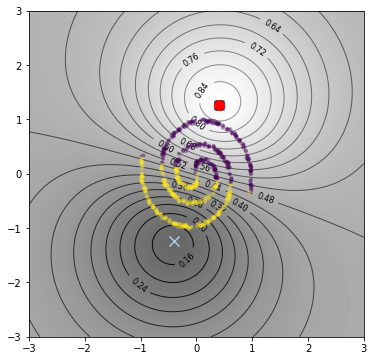

center: 0.8713159 max_grid: 0.87118226 True


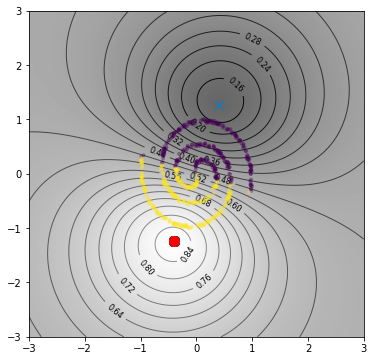

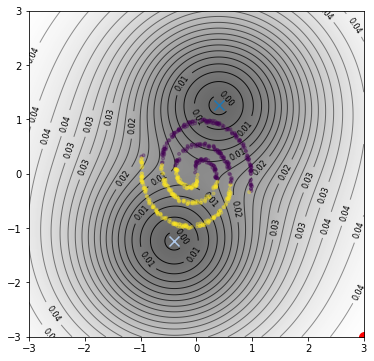

In [1805]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.centers.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [1806]:
model.bias.data, torch.exp(model.scaler)

(tensor([[ 2.4113,  2.3899, -2.4083]]),
 tensor([[2.4734]], grad_fn=<ExpBackward>))

In [1807]:
model(model.centers.data).argmax(dim=1)

tensor([0, 1])

In [1808]:
classifier = model

#### Train Residual with centers as target

In [1809]:
classifier.centers.data[[0,0,1,1]]

tensor([[ 0.4049,  1.2652],
        [ 0.4049,  1.2652],
        [-0.3976, -1.2394],
        [-0.3976, -1.2394]])

In [1829]:
model = LocalResidual_DTeSM(2, 10, epsilon=1.0, itemp=10.0)

In [1830]:
idx = torch.randperm(len(xx))[:model.layer0.centers.shape[0]]
model.layer0.centers.data = xx[idx]

In [1831]:
# classifier.centers.data[yy[idx]]

## Residual like difference
diff = classifier.centers.data[yy[idx]] - model.layer0.centers.data
model.layer1.weight.data[:, :model.layer0.centers.shape[0]] = diff.t()

In [1832]:
# model.layer1.weight.data *= 0.

In [1833]:
model.layer0.scaler.data[0,0] = 2.

In [1834]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [1835]:
yout = model(xx)
yout.shape

torch.Size([600, 2])

In [1836]:
# model.layer1.weight.data[:, -1] = model.layer1.weight.data[:, -1]*0 ## for epsilon

In [1837]:
_yy = classifier.centers.data[yy]
_yy.shape

torch.Size([600, 2])

Epoch: 99, Acc:0.75, Loss:0.6336269974708557
Epoch: 199, Acc:0.82, Loss:0.4580094814300537
Epoch: 299, Acc:0.82, Loss:0.4017471373081207
Epoch: 399, Acc:0.82, Loss:0.3699738085269928
Epoch: 499, Acc:0.80, Loss:0.3488611876964569
Epoch: 599, Acc:0.79, Loss:0.33408695459365845
Epoch: 699, Acc:0.79, Loss:0.32102784514427185
Epoch: 799, Acc:0.78, Loss:0.31150901317596436
Epoch: 899, Acc:0.78, Loss:0.3034282922744751
Epoch: 999, Acc:0.79, Loss:0.29621201753616333


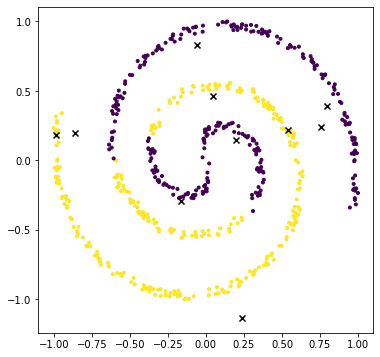

Epoch: 1099, Acc:0.79, Loss:0.28963416814804077
Epoch: 1199, Acc:0.80, Loss:0.28340885043144226
Epoch: 1299, Acc:0.81, Loss:0.27383172512054443
Epoch: 1399, Acc:0.83, Loss:0.2514478862285614
Epoch: 1499, Acc:0.84, Loss:0.24343113601207733
Epoch: 1599, Acc:0.84, Loss:0.2366848737001419
Epoch: 1699, Acc:0.85, Loss:0.22842125594615936
Epoch: 1799, Acc:0.86, Loss:0.2161400318145752
Epoch: 1899, Acc:0.92, Loss:0.17772696912288666
Epoch: 1999, Acc:0.94, Loss:0.1437421441078186


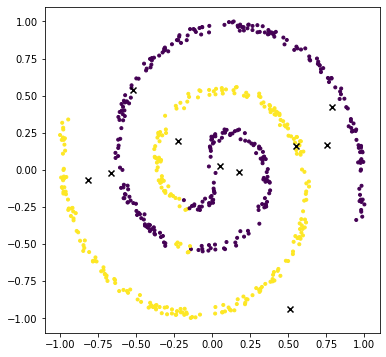

Epoch: 2099, Acc:0.95, Loss:0.13562710583209991
Epoch: 2199, Acc:0.96, Loss:0.13038061559200287
Epoch: 2299, Acc:0.96, Loss:0.1261877566576004
Epoch: 2399, Acc:0.97, Loss:0.12259413301944733
Epoch: 2499, Acc:0.97, Loss:0.11980821937322617
Epoch: 2599, Acc:0.97, Loss:0.11794284731149673
Epoch: 2699, Acc:0.97, Loss:0.11670112609863281
Epoch: 2799, Acc:0.98, Loss:0.11583128571510315
Epoch: 2899, Acc:0.98, Loss:0.11507485806941986
Epoch: 2999, Acc:0.98, Loss:0.11444421112537384


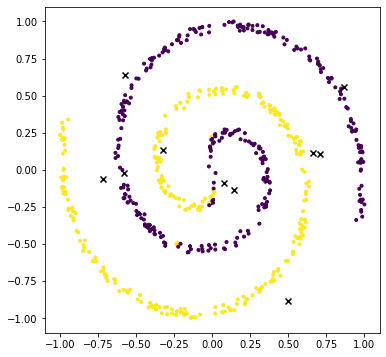

Epoch: 3099, Acc:0.99, Loss:0.11395681649446487
Epoch: 3199, Acc:0.99, Loss:0.11355641484260559
Epoch: 3299, Acc:0.99, Loss:0.11321670562028885
Epoch: 3399, Acc:0.99, Loss:0.1129244714975357
Epoch: 3499, Acc:0.99, Loss:0.1126708835363388
Epoch: 3599, Acc:0.99, Loss:0.11244932562112808
Epoch: 3699, Acc:0.99, Loss:0.11225482821464539
Epoch: 3799, Acc:0.99, Loss:0.11208732426166534
Epoch: 3899, Acc:0.99, Loss:0.11193173378705978
Epoch: 3999, Acc:0.99, Loss:0.11180749535560608


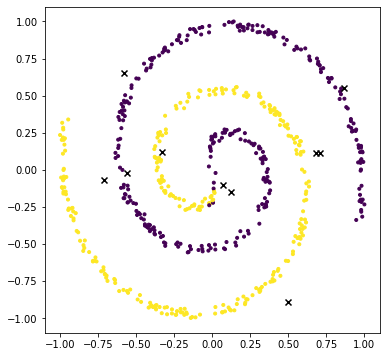

Epoch: 4099, Acc:0.99, Loss:0.11167705804109573
Epoch: 4199, Acc:0.99, Loss:0.11157291382551193
Epoch: 4299, Acc:0.99, Loss:0.11147535592317581
Epoch: 4399, Acc:0.99, Loss:0.11139002442359924
Epoch: 4499, Acc:0.99, Loss:0.11131596565246582
Epoch: 4599, Acc:0.99, Loss:0.11125498265028
Epoch: 4699, Acc:0.99, Loss:0.11118654906749725
Epoch: 4799, Acc:0.99, Loss:0.1111375167965889
Epoch: 4899, Acc:0.99, Loss:0.11108110845088959
Epoch: 4999, Acc:0.99, Loss:0.11104092746973038


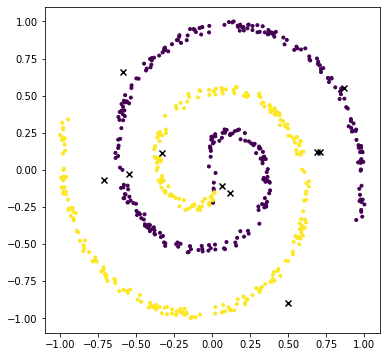

In [1838]:
%matplotlib inline

for epoch in range(5000):
    yout = model(xx)
    
    loss = criterion(yout, _yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#     model.bias.data *= 0. ## Neglect the bias use
#     model[0].layer0.scaler.data = model[0].layer0.scaler.data*0+1.
    model.layer1.weight.data[:, -1] = model.layer1.weight.data[:, -1]*0

    if (epoch+1)%100 == 0:
        yout_ = classifier(model(xx))
        accuracy = (yout_.max(dim=1)[1] == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = yout_.max(dim=1)[1].data.cpu().numpy()
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.layer0.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [1839]:
model

LocalResidual_DTeSM(
  (layer0): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer1): Linear(in_features=11, out_features=2, bias=True)
)

In [1840]:
h1 = model(xx)
yout = classifier(h1)
out = yout.max(dim=1)[1].data.cpu().numpy()
## centroids and shift
c = model.layer0.centers.data.cpu()
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

In [1841]:
max_actv = model.layer0(model.layer0.centers.data).data.cpu()
max_actv = max_actv.diag()#.numpy()
max_actv

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [1842]:
# d[:10] = d[:10]*max_actv.unsqueeze(-1)

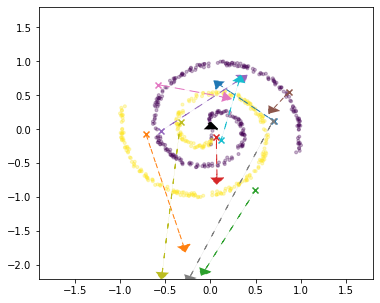

In [1843]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)
    
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

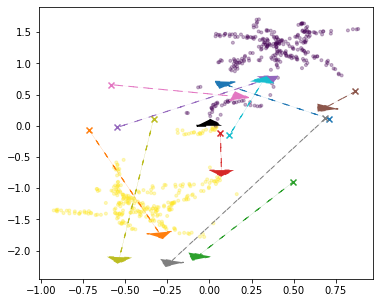

In [1844]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(h1.data[:,0], h1.data[:,1], c=out, marker= '.', alpha=0.3)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
color = "k"
ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)
    
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

### Visualize residual layer

In [1845]:
model(XX)
YY = model.layer0.temp_activ
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 11])

In [1846]:
# dir(model[0].layer0)
max_actv = max_actv.numpy()
max_actv

array([0.9999629, 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 0.9999615, 1.       , 1.       ], dtype=float32)

center: 0.9999629 max_grid: 0.9999615 True


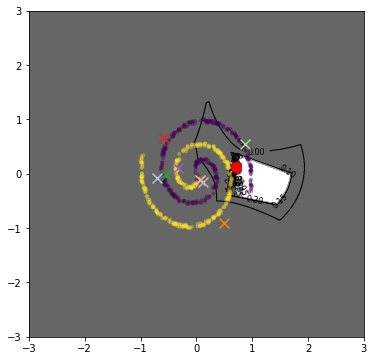

center: 1.0 max_grid: 1.0 True


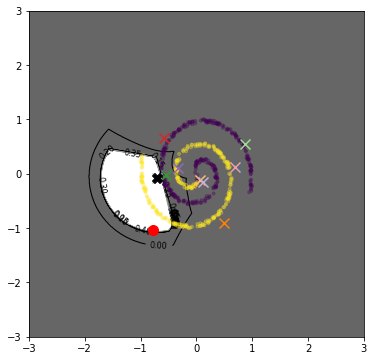

center: 1.0 max_grid: 1.0 True


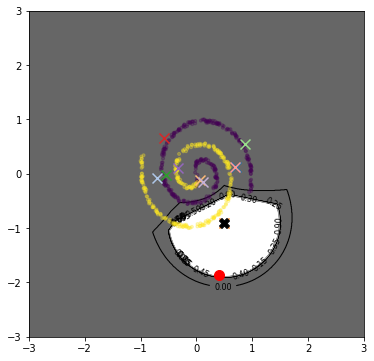

center: 1.0 max_grid: 1.0 True


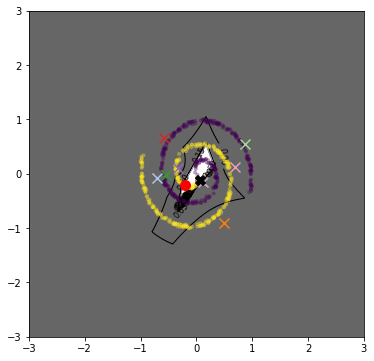

center: 1.0 max_grid: 1.0 True


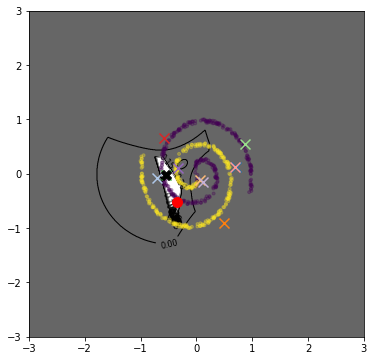

center: 1.0 max_grid: 1.0 True


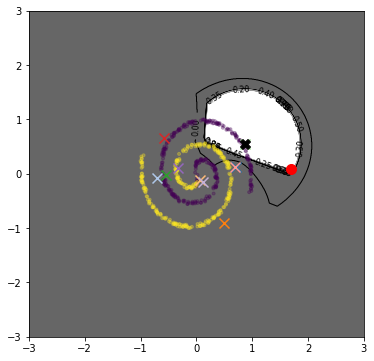

center: 1.0 max_grid: 1.0 True


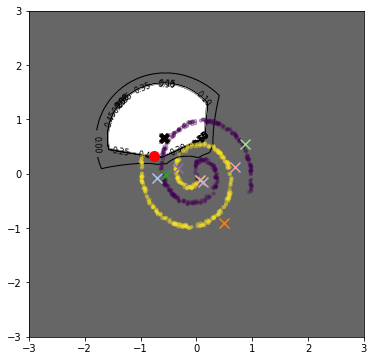

center: 0.9999615 max_grid: 0.99995804 True


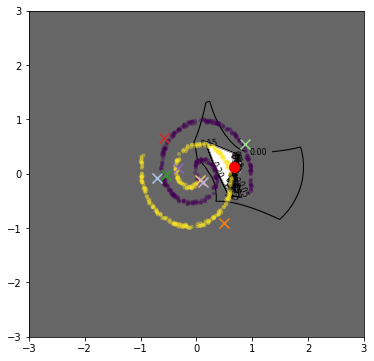

center: 1.0 max_grid: 1.0 True


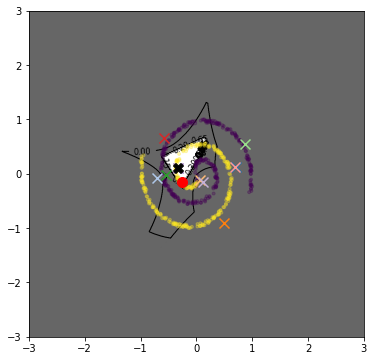

center: 1.0 max_grid: 1.0 True


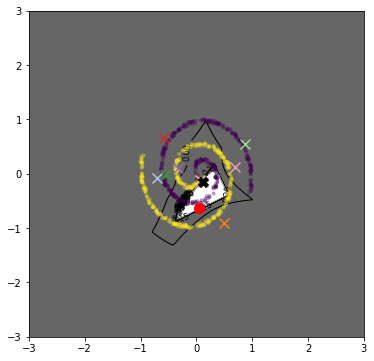

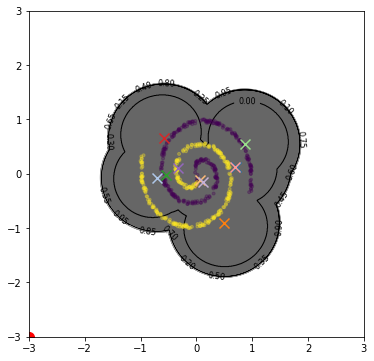

In [1847]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [1848]:
torch.exp(model.layer0.scaler), model.layer0.bias

(tensor([[99.8360]], grad_fn=<ExpBackward>), None)

## Extract information from data and gradient

In [ ]:
"""
Extract gradient information... The gradient will provide with target for newly added residual network..
"""

In [1849]:
asdasdasdsd

NameError: name 'asdasdasdsd' is not defined